In [1]:
import sys
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
from matplotlib import pyplot as plt

from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

from one.api import ONE
from brainbox.io.one import SessionLoader

import sys
sys.path.append('/home/crombie/code/ibl_photometry/src')

import util

## Query Alyx for sessions in the ibl_fibrephotometry project

In [2]:
# Instantiate a database connection
one = ONE()

In [3]:
# Query for sessions in the ibl_fibrephotometry project
df_sessions = util.fetch_sessions(one, save=True, check_local=True)

Querying database...
Checking remote datasets...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2584/2584 [27:12<00:00,  1.58it/s]
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/api.py:166: UserWarning: No cache tables found in /home/crombie/mnt/ccu-iblserver/kb/data/one
  warnings.warn(f'No cache tables found in {self._tables_dir}')


Checking local datasets...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2584/2584 [00:01<00:00, 2107.21it/s]


In [4]:
df_sessions['local_photometry'].replace({np.nan:False}).sum()

np.int64(0)

In [10]:
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [11]:
def _get_subject_info(series, one=None):
    assert one is not None
    subjects = one.alyx.rest('subjects', 'list', nickname=series['subject'])
    assert len(subjects) == 1
    subject = subjects[0]
    for key in ['strain']:
        series[key] = subject[key]
    return series

df_sessions = df_sessions.progress_apply(_get_subject_info, one=one, axis='columns').copy()
df_sessions.to_parquet('metadata/sessions.pqt', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2584/2584 [00:00<00:00, 3570.39it/s]


In [12]:
df_sessions['NM'] = df_sessions['strain'].replace({
    'Ai148xSERTCre': '5HT',
    'Ai148xDATCre': 'DA',
    'Ai148xDbhCre': 'NE',
    'Ai148xTHCre': 'NE',
    'B6.Cg': 'none',
    'Ai148xChATCre': 'ACh',
    'Ai148xDbh-Cre': 'NE',
    'B6.129S2': 'none',
    'Ai95xSERTCre': '5HT',
    'C57BL/6J': 'none'
})

In [13]:
def protocol2type(protocol):
    types = np.array(['habituation', 'training', 'biased'])
    type_mask = [t in protocol for t in types]
    if sum(type_mask) == 1:
        return str(types[type_mask][0])
    elif sum(type_mask) == 0:
        return 'misc'
    else:
        raise ValueError

df_sessions['session_type'] = df_sessions['task_protocol'].map(protocol2type)

In [14]:
df_sessions.to_parquet('metadata/sessions.pqt', index=False)

In [29]:
df_sessions[['subject', 'start_time', 'session_n', 'session_type', 'NM']].to_csv('IBL-NM_recordings.csv')

In [17]:
sessions = one.alyx.rest('sessions', 'list', project='ibl_fibrephotometry')
df_sessions = pd.DataFrame(sessions).rename(columns={'id': 'eid'})

In [3]:
# Load sessions from a saved query
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [8]:
df_sessions['local_photometry'].replace({'nan': False}).astype(bool).sum()

np.int64(905)

## Perform QC on fiber photometry sessions

In [53]:
# Filter for sessions in 2025
df_sessions2025 = df_sessions[df_sessions['start_time'].apply(lambda x: datetime.fromisoformat(x).year == 2023)].copy()

# Remove habituation sessions
df_qc = df_sessions2025.query('not task_protocol.str.contains("habituation")').sort_values(['subject', 'session_n'])

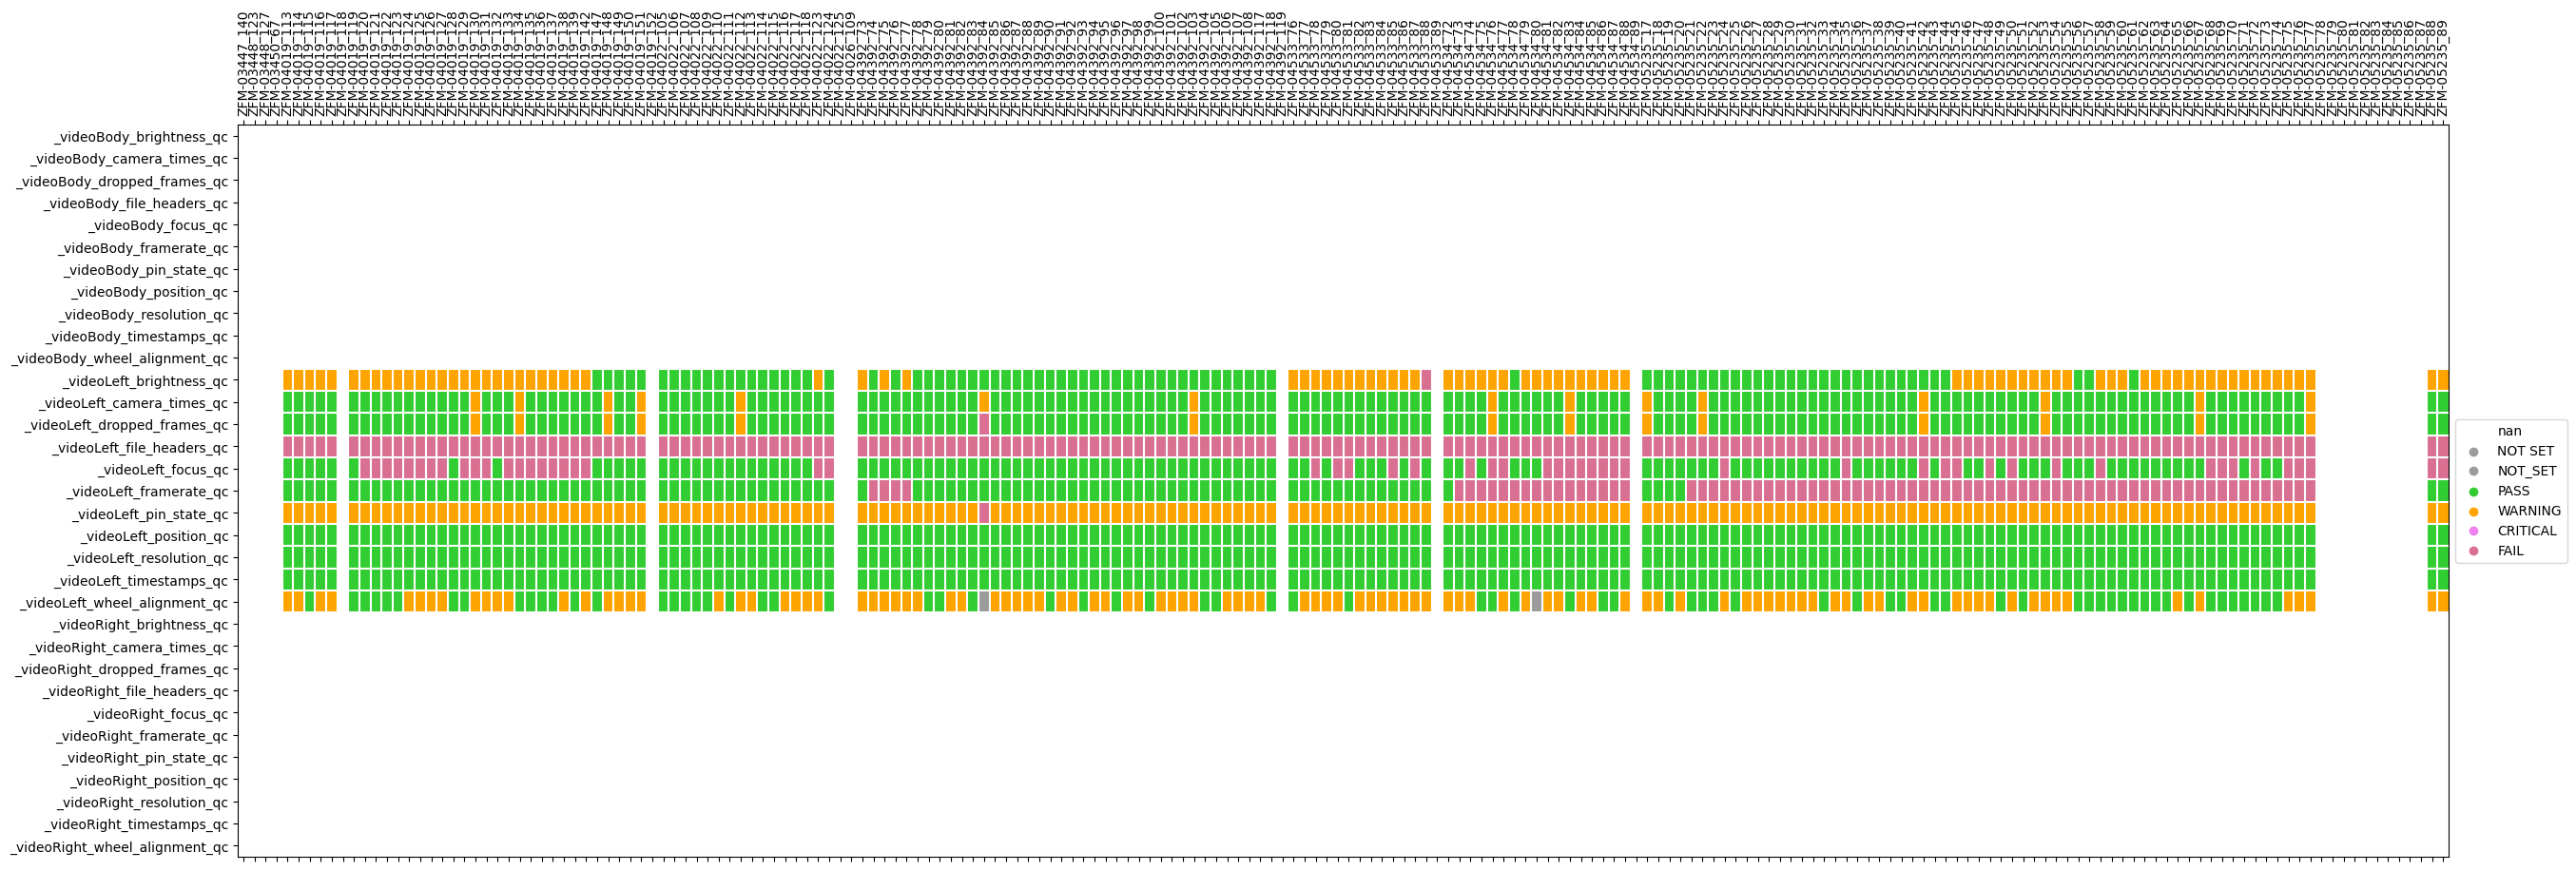

In [54]:
# Select video qc columns
qc_columns = [col for col in df_sessions2025.columns if col.startswith('_video') & col.endswith('_qc')]

# Plot qc outcomes
fig, ax = plt.subplots(figsize=(30, 10))
ax = util.qc_grid(df_qc[:200], qc_columns, xticklabels=['subject', 'session_n'], ax=ax)

<Axes: >

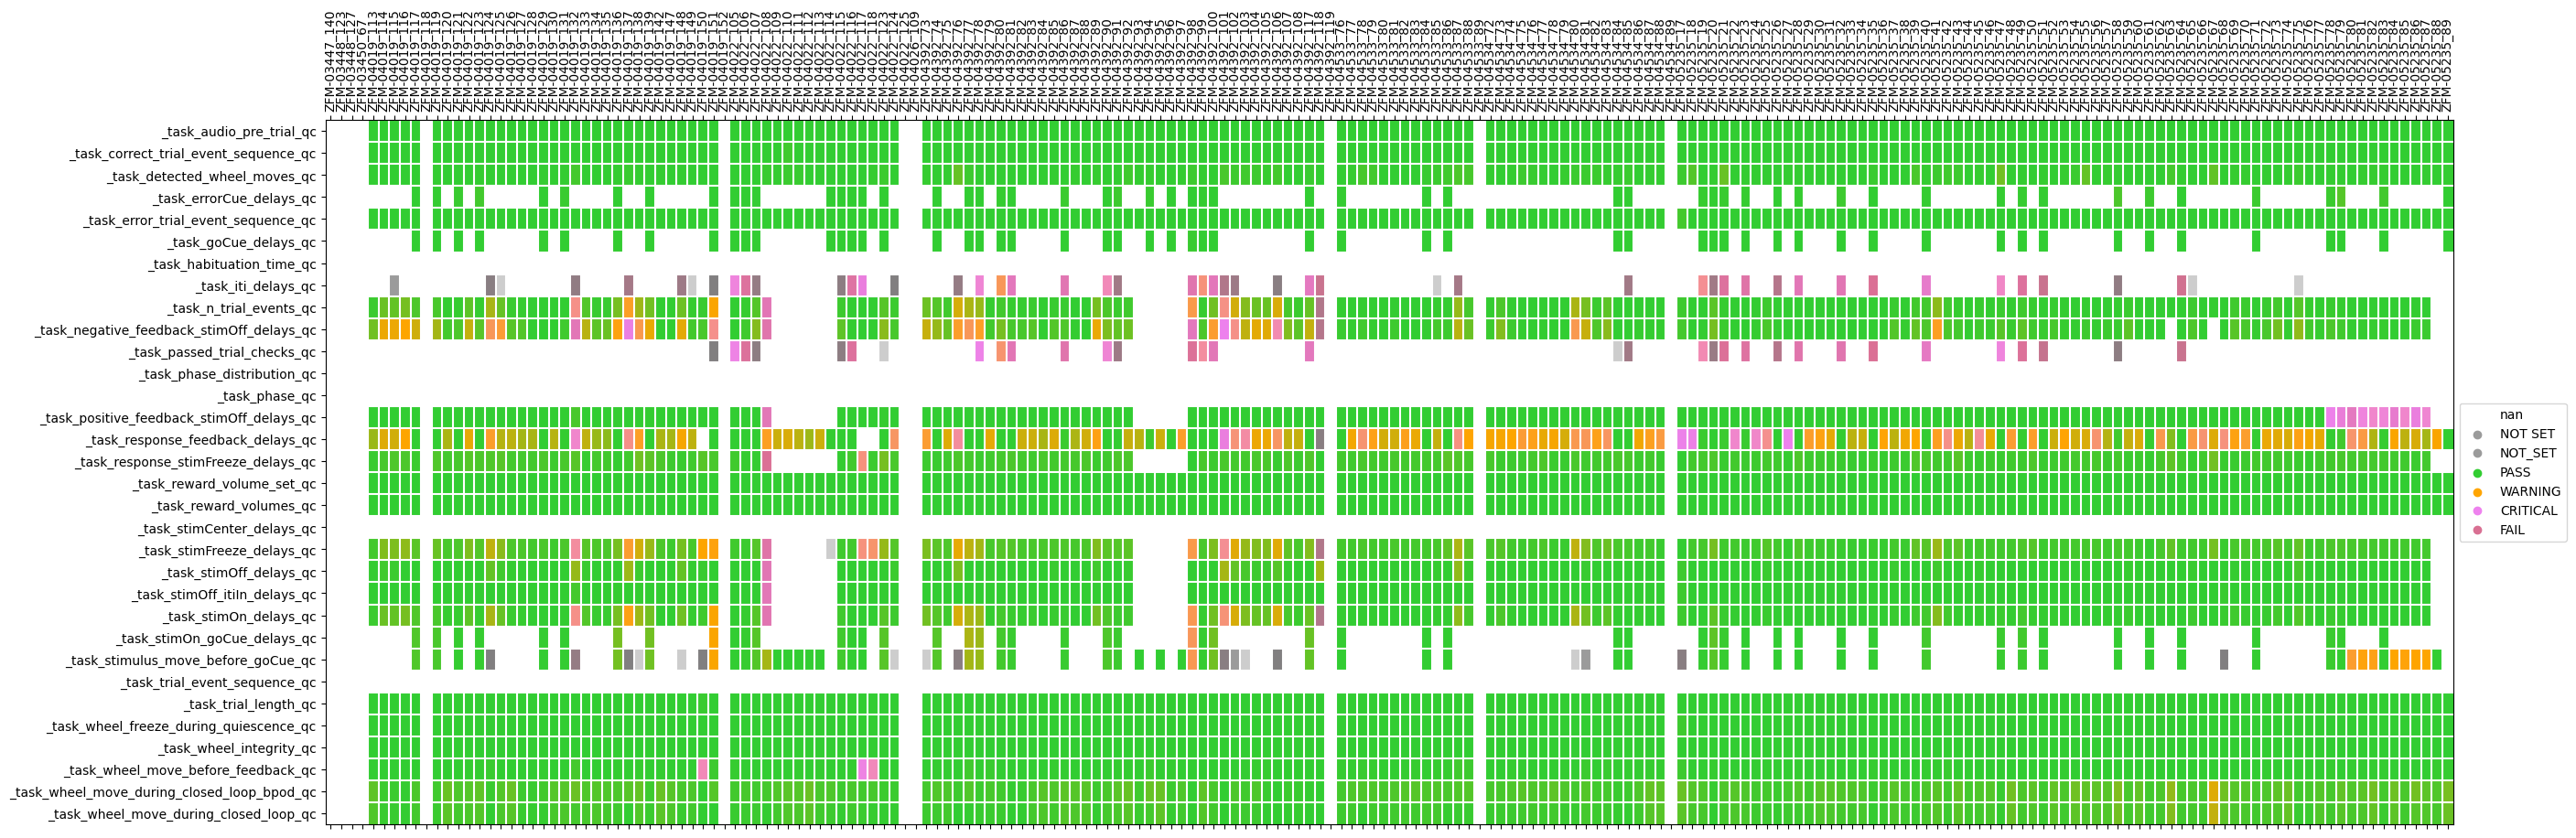

In [55]:
fig, ax = plt.subplots(figsize=(30, 10))
qc_columns = [col for col in df_sessions2025.columns if col.startswith('_task') & col.endswith('_qc')]
util.qc_grid(df_qc[:200], qc_columns, xticklabels=['subject', 'session_n'], ax=ax)

In [3]:
# Load sessions from previous query
df_sessions = pd.read_parquet('metadata/sessions.pqt')

In [10]:
# Print out some summary data
print(f"N Sessions: {len(df_sessions)}")
print(f"N Mice: {len(df_sessions['subject'].unique())}")
print(df_sessions['subject'].unique())

N Sessions: 2519
N Mice: 51
['ZFM-02128' 'ZFM-03065' 'ZFM-03059' 'ZFM-03062' 'ZFM-03061' 'ZFM-03448'
 'ZFM-03450' 'ZFM-03447' 'ZFM-04026' 'ZFM-04022' 'ZFM-04019' 'ZFM-03063'
 'ZFM-04533' 'ZFM-04534' 'ZFM-04392' 'ZFM-03064' 'ZFM-05235' 'ZFM-05236'
 'ZFM-05239' 'ZFM-05244' 'ZFM-05245' 'ZFM-05247' 'ZFM-05248' 'ZFM-05645'
 'ZFM-06272' 'ZFM-06275' 'ZFM-06268' 'ZFM-06271' 'ZFM-06171' 'ZFM-06305'
 'ZFM-06946' 'ZFM-06948' 'VIV-45585' 'VIV-45598' 'VIV-47615' 'VIV-47627'
 'CQ001' 'CQ002' 'CQ003' 'CQ004' 'SP065' 'ZFM-08488' 'ZFM-08551'
 'ZFM-08554' 'CQ005' 'CQ008' 'CQ006' 'ZFM-08652' 'ZFM-08689' 'SP067'
 'SP068']


In [7]:
subject = 'CQ005'
df_subject = df_sessions.query('subject == @subject')

In [17]:
session_dict = one.alyx.rest('sessions', 'read', id=df_subject.iloc[-3]['eid'])

In [18]:
session_dict

{'subject': 'CQ005',
 'users': ['carolina.quadrado', 'SamuelP'],
 'location': '_iblrig_cortexlab_behavior_3',
 'procedures': ['Fiber photometry', 'Behavior training/tasks'],
 'lab': 'cortexlab',
 'projects': ['ibl_fibrephotometry'],
 'type': 'Experiment',
 'task_protocol': '_iblrig_tasks_trainingChoiceWorld8.27.4',
 'number': 1,
 'start_time': '2025-03-17T15:08:06.918000',
 'end_time': '2025-03-17T15:57:48.835000',
 'narrative': '',
 'parent_session': None,
 'n_correct_trials': 481,
 'n_trials': 634,
 'url': 'https://alyx.internationalbrainlab.org/sessions/cad34b7a-ce47-4963-9a1a-dc3a9ca92e3e',
 'extended_qc': {'task_00': 'FAIL',
  'videoLeft': 'FAIL',
  '_task_iti_delays': 0.7535545023696683,
  '_videoLeft_focus': 'PASS',
  '_task_goCue_delays': 1.0,
  '_task_trial_length': 0.9479495268138801,
  '_task_stimOn_delays': 0.9968454258675079,
  '_videoLeft_position': 'PASS',
  '_task_n_trial_events': 0.9463722397476341,
  '_task_reward_volumes': 1.0,
  '_task_stimOff_delays': 1.0,
  '_vide

In [128]:
raw_photometry_datasets = [
    'raw_photometry_data/_neurophotometrics_fpData.channels.csv',
    'raw_photometry_data/_neurophotometrics_fpData.raw.pqt'
]

extracted_photometry_datasets = [
    'alf/photometry/photometry.signal.pqt',
    'alf/photometry/photometryROI.locations.pqt'
]

df_sessions['photometry_extracted'] = df_sessions.apply(lambda x: x[extracted_photometry_datasets].all(), axis='columns')
df_extracted = df_sessions.query('photometry_extracted == True').copy()

## KB data on local server

In [12]:
target2genotype = {
    'VTA': 'DAT-Cre',
    'SNc': 'DAT-Cre',
    'DR': 'SERT-Cre',
    'MR': 'SERT-Cre',
    'LC': 'DbH-Cre',
    'NBM': 'ChAT-Cre',
    'SI': 'ChAT-Cre'
}

df_insertions = pd.read_csv('insertions.csv').set_index('subject')

def _get_genotype(series, df_insertions=df_insertions):
    try:
        target = df_insertions.loc[series['subject']]['targeted_regions']
        if isinstance(target, pd.Series):
            target = target.iloc[0]
        genotype = target2genotype[target]
    except KeyError:
        genotype = 'unknown'
    return genotype

df_recordings['genotype'] = df_recordings.apply(_get_genotype, axis='columns')

/tmp/ipykernel_14629/2944090011.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_sessions = df_recordings.groupby('subject').apply(len)
/tmp/ipykernel_14629/2944090011.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bias = df_recordings.groupby('subject').apply(lambda x: any(['bias' in pr for pr in x['task_protocol']]))
/tmp/ipykernel_14629/2944090011.py:3: DeprecationWarning: DataFrameGroupBy.appl

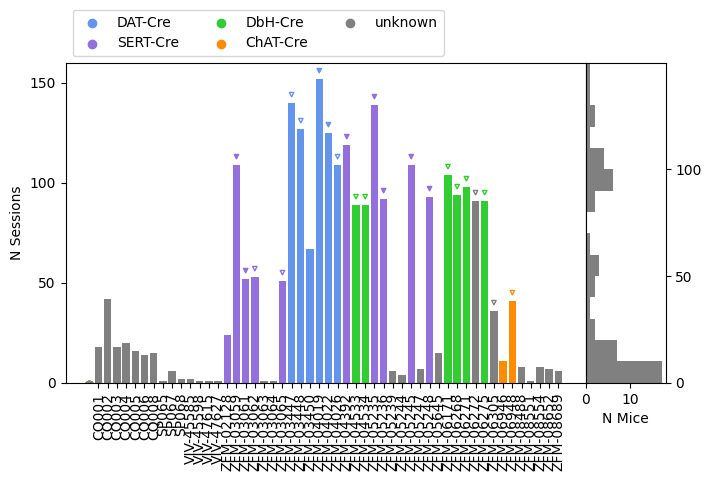

In [14]:
n_sessions = df_recordings.groupby('subject').apply(len)
bias = df_recordings.groupby('subject').apply(lambda x: any(['bias' in pr for pr in x['task_protocol']]))
ephys = df_recordings.groupby('subject').apply(lambda x: any(['ephys' in pr for pr in x['task_protocol']]))

fig = plt.figure(figsize=(8, 4))

genotype2color = {
    'DAT-Cre': 'cornflowerblue',
    'SERT-Cre': 'mediumpurple',
    'DbH-Cre': 'limegreen',
    'ChAT-Cre': 'darkorange',
    'unknown': 'gray'
}

colors = [genotype2color[subject['genotype'].iloc[0]] for _, subject in df_recordings.groupby('subject')] 
ax = fig.add_axes([0.1, 0.1, 0.65, 0.8])
for genotype, color in genotype2color.items():
    ax.scatter(-1, -1, color=color, label=genotype)
ax.bar(np.arange(len(n_sessions)), n_sessions.values, color=colors)
ax.set_xticks(np.arange(len(n_sessions)))
ax.set_xticklabels(n_sessions.index)
ax.tick_params(axis='x', labelrotation=90)
ax.set_yticks([0, 50, 100, 150])
ax.set_ylim([0, 160])
ax.set_ylabel('N Sessions')
ax.legend(ncols=3, loc='lower left', bbox_to_anchor=(0, 1))

ax_hist = fig.add_axes([0.75, 0.1, 0.1, 0.8])
ax_hist.hist(n_sessions, bins=np.linspace(0, 150, 16), orientation='horizontal', color='gray')
ax_hist.set_xlabel('N Mice')
ax_hist.yaxis.tick_right()
ax_hist.set_yticks([0, 50, 100, 160])
ax_hist.set_ylim([0, 150])

ax.scatter(np.arange(len(n_sessions))[bias], n_sessions.values[bias] + 4, s=10, marker='v', fc='none', ec=np.array(colors)[bias])
ax.scatter(np.arange(len(n_sessions))[ephys], n_sessions.values[ephys] + 4, s=10, marker='v', ec='none', fc=np.array(colors)[ephys])


In [ ]:
def _get_performance(series):
    performance = np.nan
    try:
        df_trials = one.load_dataset(series['eid'], dataset='_ibl_trials.table.pqt')
        df_highcontrast = df_trials.query('(contrastRight == 1.) | (contrastLeft == 1.)')
        performance = df_highcontrast['feedbackType'].clip(0, 1).mean()
    except:
        pass
    return performance

df_recinfo.progress_apply(_get_performance, axis='columns')

  0%|          | 0/2446 [00:00<?, ?it/s]


(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-03-28/001/alf/task_00/_ibl_trials.table.fda945f7-1df1-45e6-abf1-2d7cc369c14b.pqt Bytes: 75169



  0%|                                    | 0/0.0716867446899414 [00:00<?, ?it/s]
100%|███████████| 0.0716867446899414/0.0716867446899414 [00:00<00:00,  5.63s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2024-01-24/001/alf/task_00/_ibl_trials.table.596361c9-a7f9-4619-8d2f-59037c99d44c.pqt Bytes: 38238



  0%|                                   | 0/0.03646659851074219 [00:00<?, ?it/s]
100%|█████████| 0.03646659851074219/0.03646659851074219 [00:00<00:00, 11.54s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2024-01-24/002/alf/task_00/_ibl_trials.table.539837b8-a9e6-42b3-8b67-2b4d696bb676.pqt Bytes: 29489



  0%|                                  | 0/0.028122901916503906 [00:00<?, ?it/s]
100%|███████| 0.028122901916503906/0.028122901916503906 [00:00<00:00,  5.73s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-19/001/alf/task_00/_ibl_trials.table.69934e89-de6d-4940-99f4-43ecc976f1ed.pqt Bytes: 89641



  0%|                                   | 0/0.08548831939697266 [00:00<?, ?it/s]
100%|█████████| 0.08548831939697266/0.08548831939697266 [00:00<00:00,  5.32s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2024-01-19/001/alf/task_00/_ibl_trials.table.b1c6fcc7-3e43-43a6-a30a-73e55b46836f.pqt Bytes: 28487



  0%|                                  | 0/0.027167320251464844 [00:00<?, ?it/s]
100%|███████| 0.027167320251464844/0.027167320251464844 [00:00<00:00,  5.54s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2024-01-19/001/alf/task_00/_ibl_trials.table.805ccf7c-e72a-4a34-852a-b9a20455fa68.pqt Bytes: 36460



  0%|                                  | 0/0.034770965576171875 [00:00<?, ?it/s]
100%|███████| 0.034770965576171875/0.034770965576171875 [00:00<00:00, 10.58s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2024-01-17/001/alf/task_00/_ibl_trials.table.7078b690-1960-44b4-bab8-11861dae2fc9.pqt Bytes: 56704



  0%|                                       | 0/0.0540771484375 [00:00<?, ?it/s]
100%|█████████████████| 0.0540771484375/0.0540771484375 [00:00<00:00,  6.04s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-17/001/alf/task_00/_ibl_trials.table.b37e001e-007b-4399-a472-40c997d4189d.pqt Bytes: 69310



  0%|                                   | 0/0.06609916687011719 [00:00<?, ?it/s]
100%|█████████| 0.06609916687011719/0.06609916687011719 [00:00<00:00,  6.06s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-16/001/alf/task_00/_ibl_trials.table.b819af36-d967-4ecf-b26c-b3cf11cd2eba.pqt Bytes: 63451



  0%|                                   | 0/0.06051158905029297 [00:00<?, ?it/s]
100%|█████████| 0.06051158905029297/0.06051158905029297 [00:00<00:00,  5.31s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2024-01-15/001/alf/task_00/_ibl_trials.table.d05e973a-659c-485d-a0b0-9107505d3e72.pqt Bytes: 29970



  0%|                                  | 0/0.028581619262695312 [00:00<?, ?it/s]
100%|███████| 0.028581619262695312/0.028581619262695312 [00:00<00:00,  7.07s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2024-01-12/001/alf/task_00/_ibl_trials.table.0d529933-3d17-4bdf-aa04-95f7d90585a3.pqt Bytes: 99961



  0%|                                   | 0/0.09533023834228516 [00:00<?, ?it/s]
100%|█████████| 0.09533023834228516/0.09533023834228516 [00:00<00:00,  4.75s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2024-01-12/001/alf/task_00/_ibl_trials.table.ad114058-f4f7-4295-9b4a-33305f5b8d92.pqt Bytes: 36877



  0%|                                   | 0/0.03516864776611328 [00:00<?, ?it/s]
100%|█████████| 0.03516864776611328/0.03516864776611328 [00:00<00:00, 11.45s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2024-01-10/001/alf/task_00/_ibl_trials.table.b22f4f7e-0398-4443-b831-cac9fc47c2a4.pqt Bytes: 68041



  0%|                                   | 0/0.06488895416259766 [00:00<?, ?it/s]
100%|█████████| 0.06488895416259766/0.06488895416259766 [00:00<00:00,  4.83s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2024-01-09/001/alf/task_00/_ibl_trials.table.a2d4b89d-ac03-4747-ba95-6f1d0bfa1d86.pqt Bytes: 56012



  0%|                                  | 0/0.053417205810546875 [00:00<?, ?it/s]
100%|███████| 0.053417205810546875/0.053417205810546875 [00:00<00:00,  7.39s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-28/001/alf/task_00/_ibl_trials.table.ae146c79-5387-4070-a3a2-1648e2e74b36.pqt Bytes: 32564



  0%|                                  | 0/0.031055450439453125 [00:00<?, ?it/s]
100%|███████| 0.031055450439453125/0.031055450439453125 [00:00<00:00,  4.90s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-12-27/001/alf/task_00/_ibl_trials.table.367daf9d-7617-4a7e-b0f9-c751d7313c6f.pqt Bytes: 17580



  0%|                                  | 0/0.016765594482421875 [00:00<?, ?it/s]
100%|███████| 0.016765594482421875/0.016765594482421875 [00:00<00:00, 11.95s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-27/001/alf/task_00/_ibl_trials.table.d84b812f-ba89-4509-91e0-5b5e6a9a1156.pqt Bytes: 51207



  0%|                                  | 0/0.048834800720214844 [00:00<?, ?it/s]
100%|███████| 0.048834800720214844/0.048834800720214844 [00:00<00:00,  9.89s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-12-22/001/alf/task_00/_ibl_trials.table.ed9b6484-f651-491a-b6cb-4940ced4d9f0.pqt Bytes: 32066



  0%|                                  | 0/0.030580520629882812 [00:00<?, ?it/s]
100%|███████| 0.030580520629882812/0.030580520629882812 [00:00<00:00,  6.93s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-12-22/001/alf/task_00/_ibl_trials.table.b8bf3133-9add-468a-a94e-1d1de8393a8e.pqt Bytes: 57199



  0%|                                  | 0/0.054549217224121094 [00:00<?, ?it/s]
100%|███████| 0.054549217224121094/0.054549217224121094 [00:00<00:00,  7.68s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-20/001/alf/task_00/_ibl_trials.table.dfb8c62a-88d1-4ac6-b3ae-65d69936de7c.pqt Bytes: 40226



  0%|                                   | 0/0.03836250305175781 [00:00<?, ?it/s]
100%|█████████| 0.03836250305175781/0.03836250305175781 [00:00<00:00, 12.30s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-12-06/001/alf/task_00/_ibl_trials.table.be90035d-d7e0-4573-a289-bece4c620d2d.pqt Bytes: 50091



  0%|                                   | 0/0.04777050018310547 [00:00<?, ?it/s]
100%|█████████| 0.04777050018310547/0.04777050018310547 [00:00<00:00,  6.82s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-12-06/001/alf/task_00/_ibl_trials.table.a5b9ca18-3ce4-4b8d-a1d3-e5ebfcda9868.pqt Bytes: 27810



  0%|                                  | 0/0.026521682739257812 [00:00<?, ?it/s]
100%|███████| 0.026521682739257812/0.026521682739257812 [00:00<00:00,  5.91s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-12-06/001/alf/task_00/_ibl_trials.table.af41fd08-3e14-4f2b-b523-5a4c4a5b3491.pqt Bytes: 45408



  0%|                                     | 0/0.043304443359375 [00:00<?, ?it/s]
100%|█████████████| 0.043304443359375/0.043304443359375 [00:00<00:00,  8.74s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-11-30/001/alf/task_00/_ibl_trials.table.35797f6f-e750-4c85-9505-795917131d2c.pqt Bytes: 39186



  0%|                                   | 0/0.03737068176269531 [00:00<?, ?it/s]
100%|█████████| 0.03737068176269531/0.03737068176269531 [00:00<00:00, 13.48s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-11-29/001/alf/task_00/_ibl_trials.table.bd655ef9-b480-4f5d-939c-467f9eb9eeed.pqt Bytes: 50506



  0%|                                   | 0/0.04816627502441406 [00:00<?, ?it/s]
100%|█████████| 0.04816627502441406/0.04816627502441406 [00:00<00:00,  7.46s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-11-28/001/alf/task_00/_ibl_trials.table.6bd05034-2e44-4de8-aa1e-3ce7ed89f5da.pqt Bytes: 22544



  0%|                                    | 0/0.0214996337890625 [00:00<?, ?it/s]
100%|███████████| 0.0214996337890625/0.0214996337890625 [00:00<00:00,  9.89s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-11-17/001/alf/task_00/_ibl_trials.table.aa3c0075-b522-47b8-8da3-b408cd4e3c26.pqt Bytes: 22012



  0%|                                  | 0/0.020992279052734375 [00:00<?, ?it/s]
100%|███████| 0.020992279052734375/0.020992279052734375 [00:00<00:00,  9.82s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-11-17/001/alf/task_00/_ibl_trials.table.85dc6221-db95-4d7d-aef5-3bce347f1fdd.pqt Bytes: 36259



  0%|                                   | 0/0.03457927703857422 [00:00<?, ?it/s]
100%|█████████| 0.03457927703857422/0.03457927703857422 [00:00<00:00, 11.68s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-11-16/001/alf/task_00/_ibl_trials.table.f70d4cfa-bc38-4c71-ad2d-066cfa869196.pqt Bytes: 48676



  0%|                                  | 0/0.046421051025390625 [00:00<?, ?it/s]
100%|███████| 0.046421051025390625/0.046421051025390625 [00:00<00:00,  8.81s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-11-15/001/alf/task_00/_ibl_trials.table.6405b31c-9e8b-4cb3-b068-2128cf844b17.pqt Bytes: 41389



  0%|                                   | 0/0.03947162628173828 [00:00<?, ?it/s]
100%|█████████| 0.03947162628173828/0.03947162628173828 [00:00<00:00, 10.18s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-11-15/001/alf/task_00/_ibl_trials.table.d16d9802-0597-432a-ba58-ba8efdc23987.pqt Bytes: 17811



  0%|                                   | 0/0.01698589324951172 [00:00<?, ?it/s]
100%|█████████| 0.01698589324951172/0.01698589324951172 [00:00<00:00, 11.88s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-11-14/001/alf/task_00/_ibl_trials.table.cc5d4390-ee81-433c-9ddc-ee9938fc883d.pqt Bytes: 40696



  0%|                                   | 0/0.03881072998046875 [00:00<?, ?it/s]
100%|█████████| 0.03881072998046875/0.03881072998046875 [00:00<00:00,  8.15s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-11-13/001/alf/task_00/_ibl_trials.table.f5c88fb9-d9d2-4bd7-948d-43e4154b7f04.pqt Bytes: 14758



  0%|                                  | 0/0.014074325561523438 [00:00<?, ?it/s]
100%|███████| 0.014074325561523438/0.014074325561523438 [00:00<00:00,  8.60s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06948/2023-11-13/001/alf/task_00/_ibl_trials.table.89d29a87-a367-4b04-9740-0817dcb408f6.pqt Bytes: 27891



  0%|                                   | 0/0.02659893035888672 [00:00<?, ?it/s]
100%|█████████| 0.02659893035888672/0.02659893035888672 [00:00<00:00,  7.73s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-11-09/001/alf/task_00/_ibl_trials.table.6efc00bd-80fb-41e5-8823-4242caf426a9.pqt Bytes: 45226



  0%|                                   | 0/0.04313087463378906 [00:00<?, ?it/s]
100%|█████████| 0.04313087463378906/0.04313087463378906 [00:00<00:00,  7.52s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-11-03/001/alf/task_00/_ibl_trials.table.5fc08d06-1d96-457f-930f-9197dd45022d.pqt Bytes: 45735



  0%|                                  | 0/0.043616294860839844 [00:00<?, ?it/s]
100%|███████| 0.043616294860839844/0.043616294860839844 [00:00<00:00,  7.59s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-11-02/001/alf/task_00/_ibl_trials.table.f5d43751-c434-40fc-b495-5681b3b01318.pqt Bytes: 33098



  0%|                                   | 0/0.03156471252441406 [00:00<?, ?it/s]
100%|█████████| 0.03156471252441406/0.03156471252441406 [00:00<00:00,  5.20s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-11-02/001/alf/task_00/_ibl_trials.table.5e7f97c0-6ca9-42fb-8b15-23f68e56ffe8.pqt Bytes: 66277



  0%|                                   | 0/0.06320667266845703 [00:00<?, ?it/s]
100%|█████████| 0.06320667266845703/0.06320667266845703 [00:00<00:00,  6.52s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-10-26/001/alf/task_00/_ibl_trials.table.ae05f4ce-4c9e-4328-ba9b-c5d67c0c8e34.pqt Bytes: 66310



  0%|                                   | 0/0.06323814392089844 [00:00<?, ?it/s]
100%|█████████| 0.06323814392089844/0.06323814392089844 [00:00<00:00,  6.21s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-10-25/001/alf/task_00/_ibl_trials.table.6cdf2d11-8726-4e7c-be2e-9a71fb6c88fd.pqt Bytes: 83049



  0%|                                   | 0/0.07920169830322266 [00:00<?, ?it/s]
100%|█████████| 0.07920169830322266/0.07920169830322266 [00:00<00:00,  6.67s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-10-24/002/alf/task_00/_ibl_trials.table.d8389af8-1cb8-4943-a26b-48db784a35ad.pqt Bytes: 52881



  0%|                                  | 0/0.050431251525878906 [00:00<?, ?it/s]
100%|███████| 0.050431251525878906/0.050431251525878906 [00:00<00:00,  6.41s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-10-24/001/alf/task_00/_ibl_trials.table.49b1e384-5952-4687-8d29-dcacb8a0203f.pqt Bytes: 49303



  0%|                                  | 0/0.047019004821777344 [00:00<?, ?it/s]
100%|███████| 0.047019004821777344/0.047019004821777344 [00:00<00:00,  8.83s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-23/001/alf/task_00/_ibl_trials.table.5fbffb66-df31-418b-b722-d1ef6d4895d3.pqt Bytes: 34426



  0%|                                   | 0/0.03283119201660156 [00:00<?, ?it/s]
100%|█████████| 0.03283119201660156/0.03283119201660156 [00:00<00:00,  6.32s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-10-23/001/alf/task_00/_ibl_trials.table.ceb42e96-8ef9-4d83-b46e-64998be4e5fa.pqt Bytes: 43091



  0%|                                   | 0/0.04109477996826172 [00:00<?, ?it/s]
100%|█████████| 0.04109477996826172/0.04109477996826172 [00:00<00:00,  8.67s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-19/001/alf/task_00/_ibl_trials.table.0dc4acab-3c6f-467c-817f-600ce8c88c58.pqt Bytes: 33049



  0%|                                  | 0/0.031517982482910156 [00:00<?, ?it/s]
100%|███████| 0.031517982482910156/0.031517982482910156 [00:00<00:00,  6.22s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-10-19/001/alf/task_00/_ibl_trials.table.64f453b2-d065-4ccc-b95d-2d26b31ed08d.pqt Bytes: 59283



  0%|                                   | 0/0.05653667449951172 [00:00<?, ?it/s]
100%|█████████| 0.05653667449951172/0.05653667449951172 [00:00<00:00,  6.11s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-10-18/001/alf/task_00/_ibl_trials.table.80b26c67-49e0-4ed7-9e28-a21d6a2c52f4.pqt Bytes: 72679



  0%|                                   | 0/0.06931209564208984 [00:00<?, ?it/s]
100%|█████████| 0.06931209564208984/0.06931209564208984 [00:00<00:00,  4.55s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-18/001/alf/task_00/_ibl_trials.table.fd3e670b-492e-4a70-a1bc-6b081b8bad0c.pqt Bytes: 31143



  0%|                                  | 0/0.029700279235839844 [00:00<?, ?it/s]
100%|███████| 0.029700279235839844/0.029700279235839844 [00:00<00:00,  6.92s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-10/001/alf/task_00/_ibl_trials.table.ae3d4df8-47dc-4136-9d1f-13b0a33c7d3e.pqt Bytes: 15144



  0%|                                   | 0/0.01444244384765625 [00:00<?, ?it/s]
100%|█████████| 0.01444244384765625/0.01444244384765625 [00:00<00:00, 11.65s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-10-09/001/alf/task_00/_ibl_trials.table.9db1b224-89e0-45d0-bf03-0841a5494302.pqt Bytes: 14110



  0%|                                  | 0/0.013456344604492188 [00:00<?, ?it/s]
100%|███████| 0.013456344604492188/0.013456344604492188 [00:00<00:00, 11.55s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-10-06/001/alf/task_00/_ibl_trials.table.08862ca9-5897-418c-b4e1-7b3e5f3e7815.pqt Bytes: 28071



  0%|                                  | 0/0.026770591735839844 [00:00<?, ?it/s]
100%|███████| 0.026770591735839844/0.026770591735839844 [00:00<00:00,  7.47s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-10-06/001/alf/task_00/_ibl_trials.table.53a6a144-5baf-44cc-a19b-d159a709362e.pqt Bytes: 43240



  0%|                                   | 0/0.04123687744140625 [00:00<?, ?it/s]
100%|█████████| 0.04123687744140625/0.04123687744140625 [00:00<00:00,  7.64s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-10-05/001/alf/task_00/_ibl_trials.table.a8f38c87-ec52-47fa-b4dc-12cf8aa41515.pqt Bytes: 45062



  0%|                                   | 0/0.04297447204589844 [00:00<?, ?it/s]
100%|█████████| 0.04297447204589844/0.04297447204589844 [00:00<00:00,  9.33s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-10-05/001/alf/task_00/_ibl_trials.table.e6f7f48d-96f9-4d3d-87c9-611f91e2fda2.pqt Bytes: 54331



  0%|                                   | 0/0.05181407928466797 [00:00<?, ?it/s]
100%|█████████| 0.05181407928466797/0.05181407928466797 [00:00<00:00,  6.12s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-10-04/001/alf/task_00/_ibl_trials.table.2ea52a03-eb5e-4e14-afdd-0d4c6fe71e96.pqt Bytes: 45249



  0%|                                  | 0/0.043152809143066406 [00:00<?, ?it/s]
100%|███████| 0.043152809143066406/0.043152809143066406 [00:00<00:00,  9.47s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-10-03/001/alf/task_00/_ibl_trials.table.99d8e0a4-3ce6-4182-ade7-5c117754dca8.pqt Bytes: 22233



  0%|                                  | 0/0.021203041076660156 [00:00<?, ?it/s]
100%|███████| 0.021203041076660156/0.021203041076660156 [00:00<00:00,  7.19s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-10-03/001/alf/task_00/_ibl_trials.table.30e6aca0-5724-4209-b0fc-c0c9184cb733.pqt Bytes: 63199



  0%|                                  | 0/0.060271263122558594 [00:00<?, ?it/s]
100%|███████| 0.060271263122558594/0.060271263122558594 [00:00<00:00,  6.82s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-10-02/001/alf/task_00/_ibl_trials.table.4fc0abce-8952-4f40-ab25-ed1d4d756e67.pqt Bytes: 86177



  0%|                                    | 0/0.0821847915649414 [00:00<?, ?it/s]
100%|███████████| 0.0821847915649414/0.0821847915649414 [00:00<00:00,  7.45s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-10-02/001/alf/task_00/_ibl_trials.table.b8f5629f-77ad-4af7-a304-6b052a112e4c.pqt Bytes: 36443



  0%|                                   | 0/0.03475475311279297 [00:00<?, ?it/s]
100%|█████████| 0.03475475311279297/0.03475475311279297 [00:00<00:00, 11.65s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-09-28/001/alf/task_00/_ibl_trials.table.5ee9513e-9a1d-410e-ba3e-fa90cd7c2692.pqt Bytes: 13339



  0%|                                  | 0/0.012721061706542969 [00:00<?, ?it/s]
100%|███████| 0.012721061706542969/0.012721061706542969 [00:00<00:00, 15.81s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-09-18/001/alf/task_00/_ibl_trials.table.fe6f7318-ebbe-4975-a8cd-90f5fa73eacf.pqt Bytes: 25906



  0%|                                  | 0/0.024705886840820312 [00:00<?, ?it/s]
100%|███████| 0.024705886840820312/0.024705886840820312 [00:00<00:00,  6.06s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-09-15/001/alf/task_00/_ibl_trials.table.d066d39b-00de-4a4f-a831-0f4afa692180.pqt Bytes: 20550



  0%|                                  | 0/0.019598007202148438 [00:00<?, ?it/s]
100%|███████| 0.019598007202148438/0.019598007202148438 [00:00<00:00, 10.27s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-09-15/001/alf/task_00/_ibl_trials.table.d83b77c3-6958-4c76-b701-1487acd58acd.pqt Bytes: 35913



  0%|                                  | 0/0.034249305725097656 [00:00<?, ?it/s]
100%|███████| 0.034249305725097656/0.034249305725097656 [00:00<00:00,  9.12s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-09-14/001/alf/task_00/_ibl_trials.table.f64a633e-7a23-4899-adcf-67af18cbac77.pqt Bytes: 21973



  0%|                                   | 0/0.02095508575439453 [00:00<?, ?it/s]
100%|█████████| 0.02095508575439453/0.02095508575439453 [00:00<00:00,  7.71s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-09-07/001/alf/task_00/_ibl_trials.table.b96faa36-2f41-4afb-9a9e-39332d0535b4.pqt Bytes: 30077



  0%|                                   | 0/0.02868366241455078 [00:00<?, ?it/s]
100%|█████████| 0.02868366241455078/0.02868366241455078 [00:00<00:00,  5.63s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-09-05/001/alf/task_00/_ibl_trials.table.5fc638cf-878e-41a1-a16d-38c526eb1fc2.pqt Bytes: 20615



  0%|                                  | 0/0.019659996032714844 [00:00<?, ?it/s]
100%|███████| 0.019659996032714844/0.019659996032714844 [00:00<00:00,  8.20s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-09-05/001/alf/task_00/_ibl_trials.table.7a63eb3a-88d3-462e-ac3e-29f88e1ef460.pqt Bytes: 28275



  0%|                                   | 0/0.02696514129638672 [00:00<?, ?it/s]
100%|█████████| 0.02696514129638672/0.02696514129638672 [00:00<00:00,  7.51s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-08-31/001/alf/task_00/_ibl_trials.table.c472b87a-3e9c-475c-9f62-daac149ab7da.pqt Bytes: 25359



  0%|                                  | 0/0.024184226989746094 [00:00<?, ?it/s]
100%|███████| 0.024184226989746094/0.024184226989746094 [00:00<00:00,  8.98s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-08-31/001/alf/_ibl_trials.table.fcb55d68-438d-4f84-bc49-52c1e48e6cad.pqt Bytes: 50552



  0%|                                   | 0/0.04821014404296875 [00:00<?, ?it/s]
100%|█████████| 0.04821014404296875/0.04821014404296875 [00:00<00:00,  8.64s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-29/002/alf/_ibl_trials.table.507498b1-898a-4949-be44-e93c7a686b83.pqt Bytes: 41410



  0%|                                   | 0/0.03949165344238281 [00:00<?, ?it/s]
100%|█████████| 0.03949165344238281/0.03949165344238281 [00:00<00:00, 10.33s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-28/001/alf/task_00/_ibl_trials.table.630a2db0-70c4-4a74-8c61-95382d8bbcb9.pqt Bytes: 25667



  0%|                                   | 0/0.02447795867919922 [00:00<?, ?it/s]
100%|█████████| 0.02447795867919922/0.02447795867919922 [00:00<00:00,  6.52s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-23/001/alf/_ibl_trials.table.fba2ec95-a1ef-466c-865b-f0c3f48afa0e.pqt Bytes: 41547



  0%|                                   | 0/0.03962230682373047 [00:00<?, ?it/s]
100%|█████████| 0.03962230682373047/0.03962230682373047 [00:00<00:00,  8.91s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-08-22/001/alf/_ibl_trials.table.03f06632-826c-4376-b785-8abfdb19ef74.pqt Bytes: 54498



  0%|                                   | 0/0.05197334289550781 [00:00<?, ?it/s]
100%|█████████| 0.05197334289550781/0.05197334289550781 [00:00<00:00,  8.00s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-22/001/alf/_ibl_trials.table.06936d98-17d5-4049-ae64-91e486d0a0a9.pqt Bytes: 44172



  0%|                                  | 0/0.042125701904296875 [00:00<?, ?it/s]
100%|███████| 0.042125701904296875/0.042125701904296875 [00:00<00:00,  9.45s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-08-22/001/alf/_ibl_trials.table.4ce9b0fd-5bd5-47b2-8598-2e929ae4b79e.pqt Bytes: 71430



  0%|                                   | 0/0.06812095642089844 [00:00<?, ?it/s]
100%|█████████| 0.06812095642089844/0.06812095642089844 [00:00<00:00,  4.72s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-18/001/alf/_ibl_trials.table.24b51c48-09e1-47ee-93e3-8df44432f392.pqt Bytes: 22518



  0%|                                  | 0/0.021474838256835938 [00:00<?, ?it/s]
100%|███████| 0.021474838256835938/0.021474838256835938 [00:00<00:00,  8.68s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-08-18/001/alf/_ibl_trials.table.76dddbdb-8de7-4765-9ecd-7ea745dcf755.pqt Bytes: 53822



  0%|                                   | 0/0.05132865905761719 [00:00<?, ?it/s]
100%|█████████| 0.05132865905761719/0.05132865905761719 [00:00<00:00,  6.35s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-08-17/001/alf/task_00/_ibl_trials.table.1ba3539e-2243-41e3-91b5-79b190cc44cb.pqt Bytes: 16480



  0%|                                     | 0/0.015716552734375 [00:00<?, ?it/s]
100%|█████████████| 0.015716552734375/0.015716552734375 [00:00<00:00, 10.50s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-08-17/001/alf/_ibl_trials.table.e31d90a0-72c3-4d15-bac5-9b9009ca3aba.pqt Bytes: 36008



  0%|                                   | 0/0.03433990478515625 [00:00<?, ?it/s]
100%|█████████| 0.03433990478515625/0.03433990478515625 [00:00<00:00, 10.45s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-08-17/002/alf/_ibl_trials.table.6cd444a5-281c-4ee1-86e6-90ae7e25feb7.pqt Bytes: 61055



  0%|                                  | 0/0.058226585388183594 [00:00<?, ?it/s]
100%|███████| 0.058226585388183594/0.058226585388183594 [00:00<00:00,  6.98s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-08-16/001/alf/_ibl_trials.table.0459e8b7-5a1b-408c-81e7-758d1bfef9ae.pqt Bytes: 34661



  0%|                                   | 0/0.03305530548095703 [00:00<?, ?it/s]
100%|█████████| 0.03305530548095703/0.03305530548095703 [00:00<00:00,  6.14s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-08-15/001/alf/task_00/_ibl_trials.table.44459c4c-6fb9-4b87-8d69-7dbd47b28727.pqt Bytes: 29617



  0%|                                  | 0/0.028244972229003906 [00:00<?, ?it/s]
100%|███████| 0.028244972229003906/0.028244972229003906 [00:00<00:00,  5.60s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-07-25/002/alf/task_00/_ibl_trials.table.026bbae1-a3d3-4fc4-9698-6502188c029e.pqt Bytes: 28922



  0%|                                  | 0/0.027582168579101562 [00:00<?, ?it/s]
100%|███████| 0.027582168579101562/0.027582168579101562 [00:00<00:00,  7.42s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-25/001/alf/_ibl_trials.table.05bae42a-3971-42a9-a322-fec9db911a4b.pqt Bytes: 22225



  0%|                                  | 0/0.021195411682128906 [00:00<?, ?it/s]
100%|███████| 0.021195411682128906/0.021195411682128906 [00:00<00:00,  7.22s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-07-24/001/alf/_ibl_trials.table.772e734f-232a-469a-ae28-1be9b7ef5d07.pqt Bytes: 49202



  0%|                                   | 0/0.04692268371582031 [00:00<?, ?it/s]
100%|█████████| 0.04692268371582031/0.04692268371582031 [00:00<00:00,  8.47s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-07-21/001/alf/_ibl_trials.table.c7ca54ae-70ce-406f-859e-ab565a9ea918.pqt Bytes: 63273



  0%|                                  | 0/0.060341835021972656 [00:00<?, ?it/s]
100%|███████| 0.060341835021972656/0.060341835021972656 [00:00<00:00,  7.77s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-18/001/alf/task_00/_ibl_trials.table.e13ef817-2475-42c7-8a65-db919a1d6022.pqt Bytes: 23542



  0%|                                  | 0/0.022451400756835938 [00:00<?, ?it/s]
100%|███████| 0.022451400756835938/0.022451400756835938 [00:00<00:00,  9.02s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-07-18/002/alf/task_00/_ibl_trials.table.7a73a72e-da28-4a43-8733-9092b37069d8.pqt Bytes: 19212



  0%|                                  | 0/0.018321990966796875 [00:00<?, ?it/s]
100%|███████| 0.018321990966796875/0.018321990966796875 [00:00<00:00,  9.63s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-18/001/alf/_ibl_trials.table.fa0eab08-fd97-4c4b-bff8-5035cdd896ac.pqt Bytes: 38730



  0%|                                   | 0/0.03693580627441406 [00:00<?, ?it/s]
100%|█████████| 0.03693580627441406/0.03693580627441406 [00:00<00:00, 11.92s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-17/001/alf/_ibl_trials.table.a1f0c3df-5d5a-43d6-b4f2-aad563ad9b64.pqt Bytes: 21317



  0%|                                   | 0/0.02032947540283203 [00:00<?, ?it/s]
100%|█████████| 0.02032947540283203/0.02032947540283203 [00:00<00:00,  7.80s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-07-14/001/alf/_ibl_trials.table.7fbe147d-f94d-4350-bb48-01cb43c55e8e.pqt Bytes: 80249



  0%|                                   | 0/0.07653141021728516 [00:00<?, ?it/s]
100%|█████████| 0.07653141021728516/0.07653141021728516 [00:00<00:00,  5.06s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-14/001/alf/_ibl_trials.table.d42189f2-aaaa-425f-b67c-763cfe5a43fa.pqt Bytes: 90705



  0%|                                    | 0/0.0865030288696289 [00:00<?, ?it/s]
100%|███████████| 0.0865030288696289/0.0865030288696289 [00:00<00:00, 11.16s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06171/2023-07-14/001/alf/task_00/_ibl_trials.table.7b985802-89dc-4ad4-97bc-a871ee28254a.pqt Bytes: 19756



  0%|                                  | 0/0.018840789794921875 [00:00<?, ?it/s]
100%|███████| 0.018840789794921875/0.018840789794921875 [00:00<00:00,  9.12s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-12/008/alf/_ibl_trials.table.be2adb3f-fbc3-45e1-90dd-713186d45ddd.pqt Bytes: 86107



  0%|                                   | 0/0.08211803436279297 [00:00<?, ?it/s]
100%|█████████| 0.08211803436279297/0.08211803436279297 [00:00<00:00,  6.15s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06272/2023-07-12/001/alf/_ibl_trials.table.dc4e4c32-06d2-4e92-8f1a-e5dac748b2f1.pqt Bytes: 21239



  0%|                                  | 0/0.020255088806152344 [00:00<?, ?it/s]
100%|███████| 0.020255088806152344/0.020255088806152344 [00:00<00:00,  8.79s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-11/001/alf/_ibl_trials.table.2dca0988-44ab-4925-b77c-1cb2cd52aad2.pqt Bytes: 28933



  0%|                                   | 0/0.02759265899658203 [00:00<?, ?it/s]
100%|█████████| 0.02759265899658203/0.02759265899658203 [00:00<00:00,  5.78s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-11/001/alf/_ibl_trials.table.f39e5cd2-6010-41c2-8cb8-f1017612deab.pqt Bytes: 82584



  0%|                                   | 0/0.07875823974609375 [00:00<?, ?it/s]
100%|█████████| 0.07875823974609375/0.07875823974609375 [00:00<00:00,  7.23s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06305/2023-07-11/001/alf/_ibl_trials.table.941242cd-c278-495f-bcf7-cd71b232d7f5.pqt Bytes: 23506



  0%|                                  | 0/0.022417068481445312 [00:00<?, ?it/s]
100%|███████| 0.022417068481445312/0.022417068481445312 [00:00<00:00,  6.71s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06275/2023-07-10/001/alf/_ibl_trials.table.d841f267-36a7-4872-b048-3500625ffac0.pqt Bytes: 20768



  0%|                                     | 0/0.019805908203125 [00:00<?, ?it/s]
100%|█████████████| 0.019805908203125/0.019805908203125 [00:00<00:00,  8.54s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06268/2023-07-10/001/alf/_ibl_trials.table.0802d7d8-9137-4589-a9b3-2548a9784710.pqt Bytes: 35388



  0%|                                  | 0/0.033748626708984375 [00:00<?, ?it/s]
100%|███████| 0.033748626708984375/0.033748626708984375 [00:00<00:00, 11.35s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06271/2023-07-10/002/alf/_ibl_trials.table.e565f2c0-5be7-4440-a173-045ffcc2a40b.pqt Bytes: 14556



  0%|                                  | 0/0.013881683349609375 [00:00<?, ?it/s]
100%|███████| 0.013881683349609375/0.013881683349609375 [00:00<00:00, 14.64s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05235/2023-07-07/001/alf/task_00/_ibl_trials.table.7f338481-0c55-4adb-862d-456305795a7a.pqt Bytes: 57461



  0%|                                   | 0/0.05479907989501953 [00:00<?, ?it/s]
100%|█████████| 0.05479907989501953/0.05479907989501953 [00:00<00:00,  7.62s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-05/001/alf/_ibl_trials.table.4183e9ad-81e1-4ab6-baa7-d8e6491ff769.pqt Bytes: 52719



  0%|                                  | 0/0.050276756286621094 [00:00<?, ?it/s]
100%|███████| 0.050276756286621094/0.050276756286621094 [00:00<00:00,  6.99s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-04/001/alf/_ibl_trials.table.6ce57077-3345-4716-8798-73fc6c72f048.pqt Bytes: 46105



  0%|                                  | 0/0.043969154357910156 [00:00<?, ?it/s]
100%|███████| 0.043969154357910156/0.043969154357910156 [00:00<00:00, 17.57s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-04022/2023-07-03/001/alf/_ibl_trials.table.1cdecfc9-f88c-4dca-84b2-99134e2309e3.pqt Bytes: 22180



  0%|                                  | 0/0.021152496337890625 [00:00<?, ?it/s]
100%|███████| 0.021152496337890625/0.021152496337890625 [00:00<00:00, 10.09s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-07-03/001/alf/_ibl_trials.table.ef97048c-15c8-49f8-af08-b93c260c3979.pqt Bytes: 30061



  0%|                                   | 0/0.02866840362548828 [00:00<?, ?it/s]
100%|█████████| 0.02866840362548828/0.02866840362548828 [00:00<00:00,  7.33s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05236/2023-06-27/001/alf/_ibl_trials.table.3101b537-4c74-4159-abab-38faeac0df71.pqt Bytes: 52299



  0%|                                   | 0/0.04987621307373047 [00:00<?, ?it/s]
100%|█████████| 0.04987621307373047/0.04987621307373047 [00:00<00:00,  6.43s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-06-27/001/alf/_ibl_trials.table.46b2c9b7-94e1-4730-acb4-27ae9d90834b.pqt Bytes: 81026



  0%|                                   | 0/0.07727241516113281 [00:00<?, ?it/s]
100%|█████████| 0.07727241516113281/0.07727241516113281 [00:00<00:00,  4.43s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-27/001/alf/_ibl_trials.table.b4f4ecf1-8bba-443f-87d0-0322288e0c0c.pqt Bytes: 52089



  0%|                                  | 0/0.049675941467285156 [00:00<?, ?it/s]
100%|███████| 0.049675941467285156/0.049675941467285156 [00:00<00:00,  7.39s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Do

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-22/001/alf/_ibl_trials.table.da794512-335e-4377-8a1a-7232ac2950d9.pqt Bytes: 65316



  0%|                                  | 0/0.062290191650390625 [00:00<?, ?it/s]
100%|███████| 0.062290191650390625/0.062290191650390625 [00:00<00:00, 12.89s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-21/001/alf/_ibl_trials.table.dfd5fa58-b901-425c-91d7-fb1a8fee2101.pqt Bytes: 49305



  0%|                                  | 0/0.047020912170410156 [00:00<?, ?it/s]
100%|███████| 0.047020912170410156/0.047020912170410156 [00:00<00:00,  7.80s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05248/2023-06-20/001/alf/_ibl_trials.table.0ddfff41-4b0f-47ff-ae3b-72cc1d7a6ec8.pqt Bytes: 17571



  0%|                                   | 0/0.01675701141357422 [00:00<?, ?it/s]
100%|█████████| 0.01675701141357422/0.01675701141357422 [00:00<00:00, 13.30s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-06-20/002/alf/_ibl_trials.table.531a1457-eb83-4154-8fae-e3a10b74e777.pqt Bytes: 49205



  0%|                                   | 0/0.04692554473876953 [00:00<?, ?it/s]
100%|█████████| 0.04692554473876953/0.04692554473876953 [00:00<00:00,  6.86s/it]


Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05245/2023-06-15/002/alf/_ibl_trials.table.79027d8a-aa04-4e53-8d7b-d8b3dd3d46bb.pqt Bytes: 55067



  0%|                                   | 0/0.05251598358154297 [00:00<?, ?it/s]
100%|█████████| 0.05251598358154297/0.05251598358154297 [00:00<00:00,  6.10s/it]

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec

(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
(S3) /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjec
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/webclient.py:126: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/home/crombie/miniconda3/envs/iblenv/lib/python3.10/s

In [102]:
## Doesn't seem to work more often than not
# loader = SessionLoader(one=one, eid=eid)
# loader.load_trials()

In [95]:
from one.alf import spec

for qc in spec.QC:
    qc = str(qc).split('.')[1]
    eids_qc = one.search(projects='ibl_fibrephotometry', qc=qc)
    print(qc, len(eids_qc))
    # df_recinfo[qc] = df_recinfo.apply(lambda x: x['eid'] in list(eids_qc), axis='columns')

CRITICAL 0
FAIL 2309
WARNING 27
NOT_SET 110
PASS 0


In [ ]:
from one.alf import spec

for qc in spec.QC:
    qc = str(qc).split('.')[1]
    eids_qc = one.search(projects='ibl_fibrephotometry', dataset='trials', dataset_qc=qc)
    print(qc, len(eids_qc))
    df_recinfo[f'trials_qc'] = df_recinfo.apply(lambda x: x['eid'] in list(eids_qc), axis='columns')

CRITICAL 2296
FAIL 2296
WARNING 2296
NOT_SET 2296
PASS 2296


### Fiber photometry
So far, this data only lives on the IBL server at CCU, so we mount the server and point ONE to the mounted cache_dir.

In [8]:
cache_dir = '/home/crombie/mnt/ccu-iblserver/kb/data/one'
one = ONE(cache_dir=cache_dir)

In [7]:
subject = 'ZFM-06275'
eid = df_sessions.query('subject == @subject').iloc[7]['eid']

In [24]:
from util import _check_local_datasets

In [28]:
df_sessions = 

100%|███████████████████████████████████████| 2519/2519 [00:50<00:00, 49.91it/s]


In [34]:
extracted_photometry_datasets = [
    'alf/photometry/photometry.signal.pqt',
    'alf/photometry/photometryROI.locations.pqt'
]

df_sessions[['local_photometry'] + extracted_photometry_datasets].apply(any, axis='columns').sum()

np.int64(2456)

In [35]:
len(df_sessions)

2519

In [9]:
session_path = one.eid2path(eid)
pnames = [reg.name for reg in session_path.joinpath('alf').glob('Region*')]
for pname in pnames:
    pqt_path = session_path / 'alf' / pname / 'raw_photometry.pqt'

In [10]:
pqt_path

PosixALFPath('/home/crombie/mnt/ccu-iblserver/kb/data/one/mainenlab/Subjects/ZFM-06275/2023-07-13/001/alf/Region4G/raw_photometry.pqt')

In [23]:
os.path.isfile(pqt_path)

[autoreload of util failed: Traceback (most recent call last):
  File "/home/crombie/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/crombie/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/crombie/miniconda3/envs/iblenv/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/crombie/code/ibl_neuromodulators/util.py", line 90
    series['local_photometry'] = [os
                                

True

In [20]:
os.pqt_path

PosixALFPath('/home/crombie/mnt/ccu-iblserver/kb/data/one/mainenlab/Subjects/ZFM-06275/2023-07-13/001/alf/Region4G/raw_photometry.pqt')

In [61]:
one.search(
    lab='mainenlab',
    projects='ibl_fibrephotometry',
    dataset_qc_lte='PASS',
    query_type='local', 
    details=True
)

([], None)

In [89]:
df_recinfo = load_recinfo()

### Task performance
Query for all `ibl_fiberphotometry` experiments that pass QC.

In [19]:
eids, infos = one.search(
    lab='mainenlab',
    projects='ibl_fibrephotometry',
    dataset='trials',
    dataset_qc_lte='PASS',
    query_type='local', 
    details=True
)

# Place all metadata in a dataframe
df_eids = pd.DataFrame(infos)
df_eids['eid'] = eids
print(f"Number of sessions: {len(df_eids)}")
print(f"Number of mice: {len(df_eids.groupby('subject'))}")
# print(df_eids['subject'].unique())

Number of sessions: 2192
Number of mice: 31


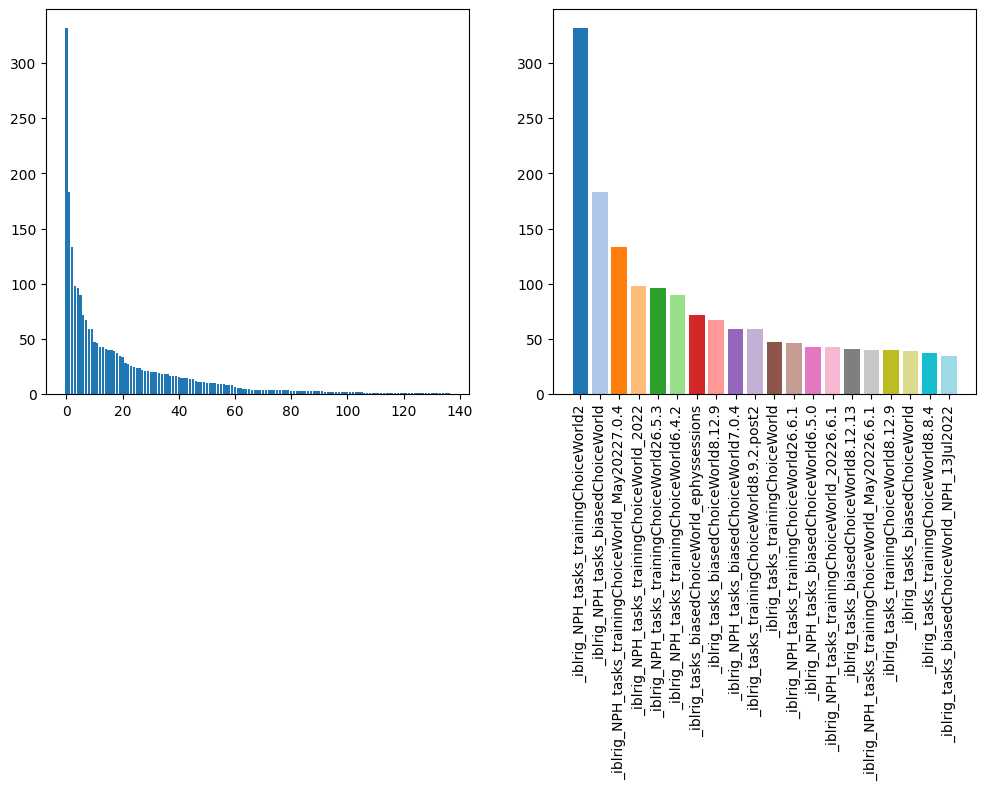

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_protocols = df_recinfo['task_protocol'].value_counts()
axs[0].bar(np.arange(len(df_protocols)), df_protocols.values)
axs[1].bar(np.arange(20), df_protocols.head(20).values, color=plt.cm.tab20(np.arange(20)))
axs[1].set_xticks(np.arange(20))
axs[1].set_xticklabels(df_protocols.head(20).index)
axs[1].tick_params(axis='x', labelrotation=90)

In [ ]:
# df_eids['data_exists'] = True
agg_dict = {
    'correct': 'mean',  # proportion correct
    'date': 'first',
    'task_protocol': 'first'
    }

for mid, mouse in df_eids.groupby('subject'):
    df_trials = pd.DataFrame()
    for _, session in mouse.iterrows():
        try:
            loader = SessionLoader(one=one, eid=session['eid'])
            loader.load_trials()
        except:
            # df_eids.loc[idx, 'data_exists'] = False
            continue
        df = loader.trials
        for data_label in ['subject', 'date', 'eid', 'task_protocol']:
            df[data_label] = session[data_label]
        df_trials = pd.concat([df_trials, df])
    
    df_trials = df_trials.reset_index().rename(columns={'index':'trial_n'})
    df_trials['contrast'] = df_trials.apply(lambda x: np.nansum([x['contrastLeft'], x['contrastRight']]), axis='columns')
    df_trials['correct'] = df_trials['feedbackType'] > 0
    df_trials = df_trials.sort_values('date')
    # df_trials.to_csv(f'data/{mid}.csv')

    break

    # df_learn = df_trials.query('contrast == 1').groupby('eid', sort=False).agg(agg_dict)
    # df_learn = df_learn.query("not task_protocol.str.contains('habituation')")

    # fig, ax = plt.subplots()
    # ax.plot(df_learn['correct'].values)
    # ax.tick_params(axis='x', labelrotation=60)

/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/